In [108]:
import torch
import os
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

def checkpoint_epoch(folder, epoch=19):
    files = os.listdir(folder)
    f = [f for f in files if "batches_{}_.pth".format(epoch) in f]
    if len(f) > 0:
        return f[0]
    return -1

def add_metadata(fname, d):
    match = re.search('width_mult_\d+(\.\d+)?', fname)
    if match:
        width_mult = match.group(0)[len("width_mult_"):]
        d["width_mult"] = float(width_mult)
    match = re.search('-lr_\d+.\d+', fname)
    if match:
        value = match.group(0)[len("-lr_"):]
        d["lr"] = float(value)
    match = re.search('-depth_mult_\d+', fname)
    if match:
        value = match.group(0)[len("-depth_mult_"):]
        d["depth_mult"] = int(value)
    match = re.search('-parametr_mup_depth', fname)
    if match:
        d["mup_depth"] = True
    else:
        d["mup_depth"] = False
        
    match = re.search('skip_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("skip_scaling_"):]
        d["skip_scaling"] = float(value)
    else:
        d["skip_scaling"] = 1.0
    
    match = re.search('res_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("res_scaling_"):]
        d["res_scaling"] = float(value)
    else:
        d["res_scaling"] = 1.0
    
    match = re.search('epoch_\d+', fname)
    if match:
        width_mult = match.group(0)[len("epoch_"):]
        d["epochs"] = int(width_mult)
        
    match = re.search('seed_\d+', fname)
    if match:
        s = match.group(0)[len("seed_"):]
        d["seed"] = int(s)
    else:
        d["seed"] = None
    
    match = re.search('beta_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("beta_"):]
        d["beta"] = float(value)
    else:
        d["beta"] = 1.0
    
    match = re.search('gamma_zero_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("gamma_zero_"):]
        d["gamma_zero"] = float(value)
    else:
        d["gamma_zero"] = 1.0
        
    match = re.search('-norm_ln', fname)
    if match:
        d["norm"] = "ln"
    elif re.search('-norm_bn', fname):
        d["norm"] = "ln"
    elif re.search('-norm_None', fname):
        d["norm"] = None
    else:
        d["norm"] = None
    
    match = re.search('k_layers_\d+', fname)
    if match:
        value = match.group(0)[len("k_layers_"):]
        d["k_layers"] = int(value)
    else:
        d["k_layers"] = None
        
    match = re.search('batch_size_\d+', fname)
    if match:
        value = match.group(0)[len("batch_size_"):]
        d["batch_size"] = int(value)
    else:
        d["batch_size"] = None
    return d


def get_data(folder_path, epoch=19):
    final_d = []
    for fp in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fp)
        d_file = checkpoint_epoch(fpath, epoch=epoch)
        if d_file != -1:
            fpath_ = os.path.join(fpath, checkpoint_epoch(fpath, epoch=epoch))
            d = torch.load(fpath_)
            d = add_metadata(fp, d)
            args_path = open(os.path.join(fpath, "args.json"))
            args = json.load(args_path)
            # d["width"] = args["width"]
            d["name"] = fp
            final_d.append(d)
    return final_d


def loss_curves(run_ds, train=True, acc=True):
    ds = []
    for d in run_ds:
        loss_d = pd.DataFrame()
        for k in d["metrics"].keys():
            try:
                loss_d[k] = d["metrics"][k]
            except Exception:
                continue
        # try:
        #     if train:
        #         loss_d["train_loss"] =  d["metrics"]["train_loss"]
        #         if acc:
        #             if "train_acc" in d["metrics"].keys():
        #                 loss_d["train_acc"] =  d["metrics"]["train_acc"]
        #         if "trace" in d["metrics"].keys() and len(d["metrics"]["trace"]) > 1:
        #             loss_d["trace"] = d["metrics"]["trace"]
        #         if "top_eig" in d["metrics"].keys() and len(d["metrics"]["top_eig"]) > 1:
        #             loss_d["top_eig"] = d["metrics"]["top_eig"]
        #     else:
        #         loss_d["test_loss"] =  d["metrics"]["test_loss"]
        #         loss_d["test_acc"] =  d["metrics"]["test_acc"]
        loss_d[f"top_eig_0"] =  d["metrics"][f"top_eig_0"]
        # loss_d[f"top_eig"] =  d["metrics"][f"top_eig"]
        loss_d["lr"] = d["lr"]
        loss_d["width_mult"] = d["width_mult"] 
        loss_d["width"] = d["width_mult"] *  64
        loss_d["depth"] = d["depth_mult"] * 6
        loss_d["depth_mult"] = d["depth_mult"]
        loss_d["step"] = loss_d.index
        loss_d["beta"] = d["beta"]
        loss_d["gamma_zero"] = d["gamma_zero"]
        loss_d["k_layers"] = d["k_layers"]
        loss_d["batch_size"] = d["batch_size"]
        loss_d["seed"] = d["seed"]
        ds.append(loss_d)
    return pd.concat(ds, axis=0)


def get_metrics_df(run_ds, metric):
    ds = []
    for d in run_ds:
        try:
            d[metric] = d['metrics'][metric][-1]
            d = {k: d[k] for k in (metric, 'lr', 'width_mult', 'depth_mult', 'mup_depth', 'norm', 'gamma_zero', 'beta', 'k_layers', 'batch_size','width', 'seed', 'top_eig_0')}
            ds.append(d)
        except KeyError as e:
            print(e)
            continue
    return pd.DataFrame(ds)

In [109]:
# folder_path = "/home/ameterez/work/nips2024/ntk_many_seeds/"
# folder_path = "/home/ameterez/work/nips2024/vit_training_with_lr_scaling"
folder_path = "/home/ameterez/work/nips2024/debug_depth_more_warmup_very_long/"
width_mult = True

In [110]:
# Power law fit:

from scipy.optimize import curve_fit

def power_law(x, A, B):
    return A * x**B
    
def power_law_fit(x, y):

    # Fit the power law model to the data
    popt, pcov = curve_fit(power_law, x, y, maxfev=10000)

    # Extract the fitting parameters
    A, B = popt
    print(f"Fitted parameters: A = {A}, B = {B}")
    return A, B

,trace,top_eig_0,train_loss,ens_train_loss,test_loss,ens_test_loss,test_acc,ens_test_acc,train_acc,ens_train_acc,...,width_mult,width,depth,depth_mult,step,beta,gamma_zero,k_layers,batch_size,seed
0,0.032190,0.004941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,64.0,48,8,0,1.0,1.0,2,None,0
1,0.385752,0.107177,2.257580,2.257580,1.871806,2.302585,32.02,10.0,15.659808,15.659808,...,1.0,64.0,48,8,1,1.0,1.0,2,None,0
2,0.686543,0.044429,1.836985,1.836985,1.626177,2.302585,41.07,10.0,33.659499,33.659499,...,1.0,64.0,48,8,2,1.0,1.0,2,None,0
3,0.756300,0.025279,1.674166,1.674166,1.558759,2.302585,44.53,10.0,40.655941,40.655941,...,1.0,64.0,48,8,3,1.0,1.0,2,None,0
4,0.962055,0.030727,1.501345,1.501345,1.492838,2.302585,46.11,10.0,46.789913,46.789913,...,1.0,64.0,48,8,4,1.0,1.0,2,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,4.141628,0.255633,1.311537,1.311537,1.331079,2.302585,51.77,10.0,53.511757,53.511757,...,1.0,64.0,48,8,16,1.0,1.0,2,None,0
17,3.344593,0.232668,1.294956,1.294956,1.296624,2.302585,53.86,10.0,54.439975,54.439975,...,1.0,64.0,48,8,17,1.0,1.0,2,None,0
18,3.644351,0.210562,1.264041,1.264041,1.303230,2.302585,52.67,10.0,55.221225,55.221225,...,1.0,64.0,48,8,18,1.0,1.0,2,None,0
19,3.772363,0.231214,1.257197,1.257197,1.393076,2.302585,50.32,10.0,55.526764,55.526764,...,1.0,64.0,48,8,19,1.0,1.0,2,None,0


/tmp/ipykernel_799061/1983715408.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t[name] = df_t[metric1] - df_max[metric1]
/tmp/ipykernel_799061/1983715408.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t[name] = np.abs(df_t[name])
/tmp/ipykernel_799061/1983715408.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,train_loss,depth,step,seed,$|\mathcal{L}(f_\infty) - \mathcal{L}(f_N)|$,Step,Depth
1,2.265910,12,1,0,0.008602,1,12
2,1.846292,12,2,0,0.038013,2,12
3,1.676082,12,3,0,0.014689,3,12
4,1.545080,12,4,0,0.040620,4,12
5,1.489765,12,5,0,0.077857,5,12
...,...,...,...,...,...,...,...
16,1.031757,48,16,1,0.065092,16,48
17,1.012486,48,17,1,0.069048,17,48
18,0.994463,48,18,1,0.075918,18,48
19,0.975342,48,19,1,0.088296,19,48


Fitted parameters: A = 0.014871996575969269, B = 1.085486789025253
Fitted parameters: A = 0.00637117139165818, B = 1.2385439453912455
Fitted parameters: A = 0.00023688446314715266, B = 2.105017409583057


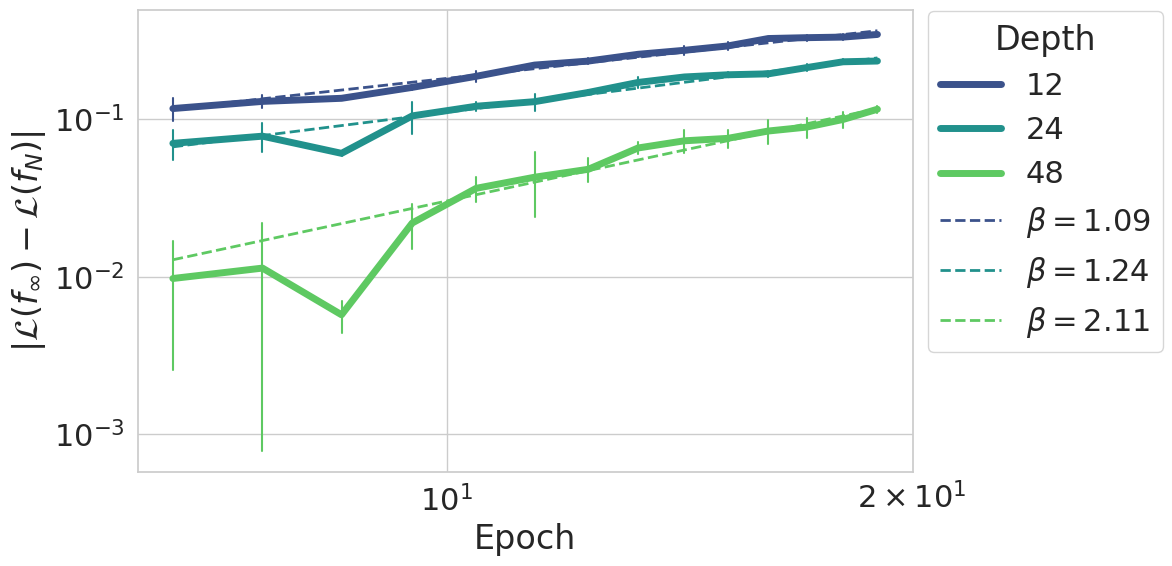

In [114]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=3))
plt.figure(figsize = (10,6))
metric1 = "train_loss"

dist_from_eos = False
abs_value = True

epoch = 19
chosen_depths = [12, 24, 48]
max_depth = 192

name = r"$|\mathcal{L}(f_\infty) - \mathcal{L}(f_N)|$"
run_ds = get_data(folder_path, epoch=epoch)
df = loss_curves(run_ds)
display(df)

lrs = sorted(df['lr'].unique())
df = df[df['lr'] == lrs[11]]
df = df[[metric1, "depth", "step", "seed"]]
#df = df[df["step"].isin(chosen_steps)]
df_aux = df.copy()
df = df[~df[metric1].isna()]
# df["coeff"] = df["depth"]
# df[metric1] = df[metric1] * df["coeff"]


# df[metric1] = df[metric1].rolling(3).mean()
df = df.dropna()
df = df[~df[metric1].isna()]

# print(df)

seeds = df["seed"].unique()
steps = df["step"].unique()
dfs = []
for s in seeds:
    for t in chosen_depths:
        df_t = df[(df["depth"] == t) & (df["seed"] == s)]
        df_max = df[(df["depth"] == max_depth) & (df["seed"] == s)]
        
        df_t[name] = df_t[metric1] - df_max[metric1]
        if abs_value:
            df_t[name] = np.abs(df_t[name])
        dfs.append(df_t)
df = pd.concat(dfs)
# steps = np.unique(np.linspace(1,epoch, num=50)).astype(int)
# df = df[df["step"].isin(steps)]

df["Step"] = df["step"]
df["Depth"] = df["depth"]

# print("Widths")
df = df[~df["Depth"].isna()]
# print(df["Width"].unique())
df = df.astype({"Depth": np.int32})
display(df)

df = df[~df[name].isna()]
df['Epoch'] = (df['Step']/df['Step'].max())*epoch
df = df[df['Epoch'] >= 6]
ax = sns.lineplot(data=df, x='Epoch', y=name, hue="Depth", linewidth = 5.0, palette=sns.color_palette("viridis", n_colors=3), legend=True, err_style='bars')
#plt.colorbar(sns.color_palette("viridis", n_colors=n_colors))
# xs = df["width"].unique()
# xs.sort()
# ys = (1/np.sqrt(xs))*np.sqrt(xs[0])
# plt.plot(xs, ys, linestyle='dashed', color='black')

# plt.hlines(1e-1, 0, max(df["Step"]), linestyle="dashed", colors='black')

# ys = np.sqrt(xs / xs[0]) * 5*10**(-3)
# plt.plot(xs, ys, linestyle='dashed', color='black')
# ys = (1/xs)*xs[0]
# plt.plot(xs, ys, linestyle='dashed', color='black')
df = df[["Epoch", "seed", "Depth", name]]

res = df.groupby(["Epoch", "seed", "Depth"], as_index=False).mean()
# print(res)

for n in df["Depth"].unique():
    df_n = res[res["Depth"] == n]
    x = df_n["Epoch"]
    y = df_n[name]
    A, B = power_law_fit(np.asarray(x), np.asarray(y))
    ax.plot(x, power_law(x, A, B), label=r'$\beta = {{{}}}$'.format(str(round(B, 2))), linestyle="dashed", linewidth = 2.0)
    
ax.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left', title="Depth")
ax.set_ylabel(name)



# plt.ylim(2e-2, 2.5)
#plt.xlim(df["Step"].min(), df["Step"].max())
plt.yscale('log')
plt.xscale('log')

# from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, LogLocator, LogFormatter

# ax.grid(True, which='minor', linestyle='-', linewidth=0.5, color='gray')
# # ax.set_xticklabels([])
# # #ax.tick_params(axis='x', which='both', labelbottom=False)

# # ax.set_yticklabels([])

# # print(ax.get_xticks())
# # xlabels = ['{:,.2f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
# # ax.set_xticklabels(xlabels)

# #ax.xaxis.set_minor_locator(MultipleLocator(10)) 
# ax.xaxis.set_minor_locator(plt.MaxNLocator(4))
# ax.yaxis.set_minor_locator(plt.MaxNLocator(4))

plt.savefig("convnet_depth_loss_trend_cifar10.pdf", format='pdf', bbox_inches='tight')
